# Integration Demo

Following is a step-by-step guide comparing the two integration approaches use in the GaussianNEGF package. All steps have been tested on a 20 core system with each step running in seconds except for the final IV step, which can take minutes.

## System Setup

We will be working with an ethane molecule:
<img src="ethane.png" alt="drawing" width="200"/>

**Basis set:** 6-31g(d,p) -  C atoms will have 15 basis functions and H will have 5

**Functional:** B3LYP Hydbrid functional

For this system we will use a diagonal self energy matrix, with $\Gamma_i=0.1$ ($\Sigma_i = -0.05j$). Because this is an energy independent self-energy, we can first test the system using the `NEGF()` type object from the `scf.py` file.

## Energy Independent Approach
To set up the system lets first import the packages and initialize the ethane system:

In [1]:
from scf import NEGF
from density import *
from surfGBethe import *
from matplotlib import pyplot as plt

negf = NEGF(fn='ethane', func='b3lyp', basis='6-31g(d,p)', spin='r')
print(negf.bar.ian)

Calculation started at Wed Jan 22 22:49:45 2025
Checkpoint not loaded, running full SCF...
Done!
ORBS:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 4 4
 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8]
Expecting 18 electrons
Actual:  18.000000000000032 electrons
Charge is: 0
Multiplicity is: 1
Initial SCF energy:  -79.83560168196276
###################################
[6 6 1 1 1 1 1 1]


The gaussian interface `QCBinAr` object is stored in `negf.bar`.

The atomic numbers for each atom are stored in `negf.bar.ian`, which are C, C, H, H, H, H, H, H

Now we can attach the contacts to both carbon atoms:

In [2]:
negf.setSigma([1], [2], -0.05j)

Max imag sigma: 0.050000001


And set the voltage to zero, setting the Fermi energy to the default value $\left(\frac{E_H + E_L}2\right)$:

In [3]:
negf.setVoltage(0)

Setting initial Fermi energy between HOMO (-9.40 eV) and LUMO (2.91 eV)


Now let's run a quick NEGF-DFT job setting the convergence to $10^{-4}$ and the mixing factor to 0.05:

Entering NEGF-SCF loop at: Wed Jan 22 22:50:09 2025
###################################

Iteration 0:
Bisection fermi search converged to 3.46E-05 in 18 iterations.
Fermi Energy set to -9.31 eV
Applying Damping value= 0.1
Total number of electrons (NEGF): 18.00
MaxDP: 2.74E+00 | RMSDP: 5.04E-01
SCF energy:  -79.80041028376775
Energy difference is: 3.519E-02

Iteration 1:
Bisection fermi search converged to 2.14E-04 in 18 iterations.
Fermi Energy set to -9.36 eV
Applying Damping value= 0.1
Total number of electrons (NEGF): 18.00
MaxDP: 2.47E+00 | RMSDP: 4.54E-01
SCF energy:  -79.76875322525451
Energy difference is: 3.166E-02

Iteration 2:
Bisection fermi search converged to 6.44E-04 in 18 iterations.
Fermi Energy set to -9.39 eV
Applying Damping value= 0.1
Total number of electrons (NEGF): 18.00
MaxDP: 2.22E+00 | RMSDP: 4.08E-01
SCF energy:  -79.74029475352452
Energy difference is: 2.846E-02

Iteration 3:
Bisection fermi search converged to -3.70E-04 in 18 iterations.
Fermi Energy set t

Text(0, 0.5, 'Total DFT Energy (eV)')

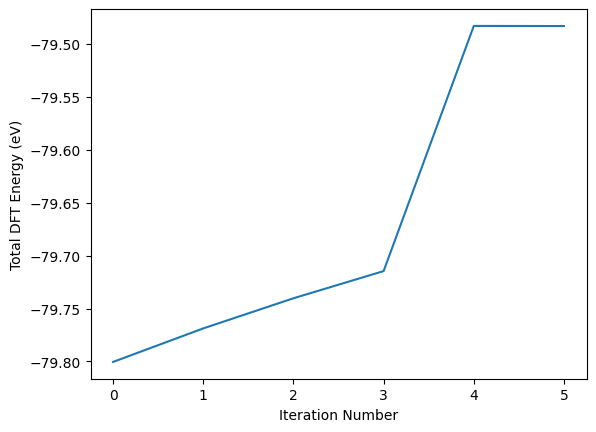

In [4]:
nIter, neList, Elist = negf.SCF(1e-3, 0.1)
# Plot convergence of DFT Energy
plt.plot(nIter, Elist)
plt.xlabel('Iteration Number')
plt.ylabel('Total DFT Energy (eV)')

A quick check of the SCF run can be done by looking at the energy level occupation list printed at the end of the run. As can be seen, the Fermi energy ends up close to the HOMO energy, and the occupation of HOMO energy and below is close to 1.0 whereas all higher energy levels have occupations near 0.0. We can also look at the main diagonal of the density matrix to understand how the atomic orbitals are occupied, multiplying by 2 to account for spin:

Text(0.5, 1.0, '$\\mathbb{Im}\\left[\\rho_{ii}\\right]$')

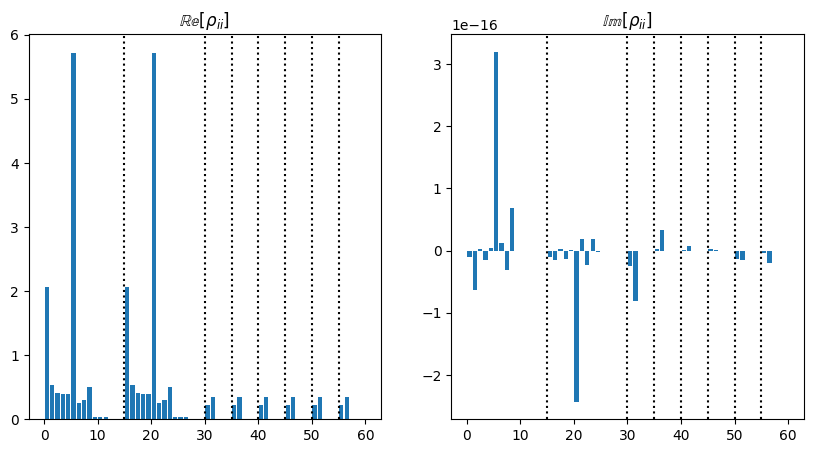

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
rho = negf.P * 2

# Count number of basis functions per atom:
atlocs = np.cumsum([(negf.bar.ibfatm==i+1).sum() for i in range(negf.bar.natoms-1)])
# Plot dividing lines between each atom
for a in atlocs:
    ax1.axvline(a, color='k', linestyle=':')
    ax2.axvline(a, color='k', linestyle=':')

# Plot real part of the diagonal of the density matrix
ax1.bar(np.arange(len(negf.P))+0.5, np.diag(rho.real))
ax1.set_title(r'$\mathbb{Re}\left[\rho_{ii}\right]$')
# Plot imaginary part of the diagonal of the density matrix
ax2.bar(np.arange(len(negf.P))+0.5, np.diag(rho.imag))
ax2.set_title(r'$\mathbb{Im}\left[\rho_{ii}\right]$')

To integrate the energy independent case, an analytical solution was used by solving the integral equation:

$$
    2 \pi \hat{\rho}_j = \hat{S}^{-\frac12}\left[ \int_{-\infty}^{\infty} f_j(E) \left(\sum_n \frac{|n\rangle}{E - \epsilon_n} \right) \langle n|\bar{\Gamma}_j |n'\rangle \right. \nonumber \\
   \left.  \left(\sum_{n'} \frac{\langle n'|}{E - \epsilon_n^\dagger} \right) dE  \right] \hat{S}^{-\frac12} \ \ \ 
   $$

where

$$
\bar{\Gamma}_j = \hat{S}^{-\frac12}\hat{\Gamma}_j\hat{S}^{-\frac12}\\
\bar{G} = (E \hat{I} - \bar{F})^{-1}\\
\bar{F} =  \hat{S}^{-\frac12}(\hat{F} + \hat{\Sigma}_L + \hat{\Sigma}_R)  \hat{S}^{-\frac12}\\
\bar{F}|n\rangle= \epsilon_n |n\rangle
$$

and $j$ represents the contribution from the jth contact. Note that we will assume that the temperature is zero, so the Fermi function ($f_j(E)$) can be replaced with a finite integral up to $E_{F, j}$. 

In our case, two contacts are applied (the left and right) so

$$
\hat{\rho} = \hat{\rho}_L + \hat{\rho}_R
$$

Since $\bar{\Gamma}_j$ is constant with respect to energy, the solution can be solved without numerical integration, calculating the value of the analytical solution at the integration limits (some $E_{min}$ to represent negative infinity and the fermi energy $E_F$). This matrix math only requires a single diagonalization of $\bar{F}$ to get the values of $\epsilon_n$ and a single matrix exponent to get $\hat{S}^{-\frac12}$. To test this math, we can use numerical integration methods that allow for an energy dependent $\hat{\Gamma}_j$.

## ENERGY DEPENDENT APPROACH

First, let us import the energy dependent packages and set up the same system:

In [6]:
from scfE import NEGFE

negf2 = NEGFE(fn='ethane', func='b3lyp', basis='6-31g(d,p)', spin='r')
print(negf2.bar.ian)

Calculation started at Wed Jan 22 22:50:18 2025
Checkpoint not loaded, running full SCF...
Done!
ORBS:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 4 4
 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8]
Expecting 18 electrons
Actual:  18.000000000000025 electrons
Charge is: 0
Multiplicity is: 1
Initial SCF energy:  -79.83560168196233
###################################
[6 6 1 1 1 1 1 1]


Now, we can set the contact on our `NEGFE()` object for ethane:

In [7]:
indsList = negf2.setSigma([1], [2], -0.05j)

Max imag sigma: 0.050000001


And then we can set the voltage and calculate the energy mesh used for numerical integration (based on the results from 2 initial SCF cycles with the default grid):

In [9]:
negf2.setVoltage(0.0)
negf2.integralCheck(cycles=4)

Setting initial Fermi energy between HOMO (-9.40 eV) and LUMO (2.91 eV)
RUNNING SCF FOR 4 CYCLES USING DEFAULT GRID: 
Entering NEGF-SCF loop at: Wed Jan 22 22:50:35 2025
###################################

Iteration 0:
Calculating lower density matrix:
Real integration over 50 points...
Integration done!
MULLER METHOD:
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration done!
Complex Integration over 100 points...
Integration 

Integration done!
MaxDP = 1.22E-06
Final Nreal: 32.0
Real integration over 32.0 points...
Integration done!
CALCULATING FERMI ENERGY
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration done!
Complex Integration over 64.0 points...
Integration don

Finally, we can run the SCF with the same parameters as before ($10^{-3}$, mixing of 0.1):

In [ ]:
nIter, neList, Elist = negf2.SCF(1e-3, 0.02)
# Plot convergence of DFT Energy
plt.plot(nIter, Elist)
plt.xlabel('Iteration Number')
plt.ylabel('Total DFT Energy (eV)')

This method use complex contour integration of the retarded Green's function to calculate the density matrix, based on the following equation.

$$
\hat{\rho} =  -\frac{1}{\pi}\mathbb{Im}\left[\int_{-\infty}^{E_F} \hat{G}^R(E) dE \right]      
$$

Note that this assumes that temperature is zero, as used in the energy-independent case.

## Comparison of Approaches

We can now compare the generated density matrices side by side:

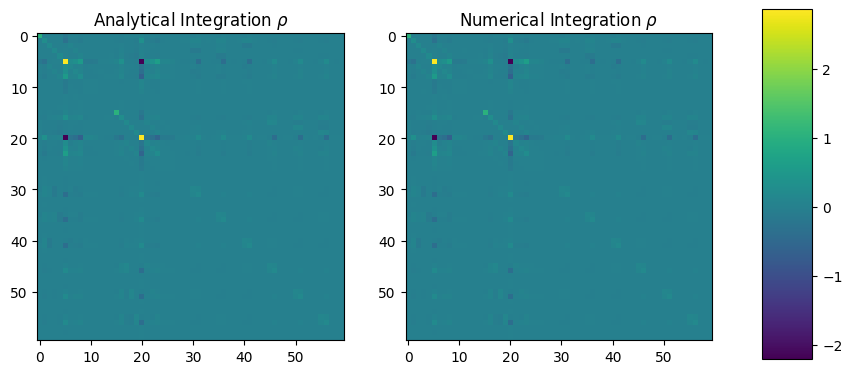

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
im = ax1.imshow(negf.P.real)
ax1.set_title(r'Analytical Integration $\rho$')
im2 = ax2.imshow(negf2.P.real)
ax2.set_title(r'Numerical Integration $\rho$')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)

As a second check, we can calculate the density of states using each method. First, we need to import the `transport` package and generate the energy grid, then calculate DOS for each object:

In [12]:
from transport import *

Elist = np.linspace(-20, 20, 1000)
DOS1, _ = DOS(Elist+negf.fermi, negf.F, negf.S, negf.sigma1, negf.sigma2)
DOS2, _ = DOSE(Elist+negf2.fermi, negf2.F, negf2.S, negf2.g)

Energy: -29.550161182156288 eV, DOS= 0.31473950455108807
Energy: -29.510121142116247 eV, DOS= 0.3155257079403215
Energy: -29.470081102076207 eV, DOS= 0.3163148335334472
Energy: -29.430041062036167 eV, DOS= 0.31710689569531
Energy: -29.390001021996127 eV, DOS= 0.31790190887829944
Energy: -29.349960981956087 eV, DOS= 0.3186998876229951
Energy: -29.309920941916047 eV, DOS= 0.3195008465588276
Energy: -29.269880901876007 eV, DOS= 0.3203048004046598
Energy: -29.229840861835967 eV, DOS= 0.32111176396952973
Energy: -29.189800821795927 eV, DOS= 0.32192175215319985
Energy: -29.149760781755887 eV, DOS= 0.3227347799469393
Energy: -29.109720741715847 eV, DOS= 0.32355086243407233
Energy: -29.069680701675807 eV, DOS= 0.32437001479074395
Energy: -29.029640661635767 eV, DOS= 0.3251922522865479
Energy: -28.989600621595727 eV, DOS= 0.3260175902852394
Energy: -28.949560581555687 eV, DOS= 0.32684604424540925
Energy: -28.909520541515647 eV, DOS= 0.3276776297211763
Energy: -28.869480501475607 eV, DOS= 0.3285

Text(0, 0.5, 'Density of States')

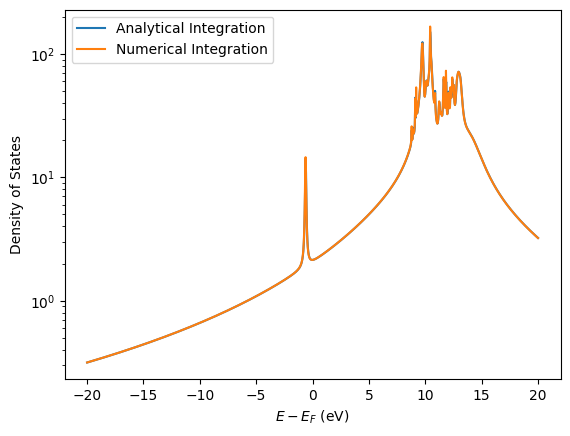

In [13]:
plt.semilogy(Elist, DOS1, Elist, DOS2)
plt.legend(('Analytical Integration', 'Numerical Integration'))
plt.xlabel(r'$E-E_F$ (eV)')
plt.ylabel('Density of States')

## IV Characteristic Comparison

We can now use NEGF to sweep the voltage and calculate current across the molecule. This requires using the NEGF-DFT solver at each voltage point to calculate the transmission and then integrating to get the current. For $T=0 K$ the fermi function becomes a step function and the Landauer formula simplifies to:

$$
I(V)= \frac{q^2}{h}\int_{\mu - \frac{qV}{2}}^{\mu + \frac{qV}{2}} T(E, V) dE
$$

which is calculated after convergence using the `quickCurrent()` and `quickCurrentE()` functions from `transport.py` (_NOTE: This calculation can take some time to run_):

In [17]:
# Voltage from 0 to 0.5 to -0.5 to 0
Vlist = list(np.arange(0.1, 0.5, 0.1))
Vlist += list(np.arange(0.5, -0.5, -0.1))
Vlist +=  list(np.arange(-0.5, 0.1, 0.1))
Ilist = []
IlistE =[]
for V in Vlist:
    print(f'SETTING VOLTAGE: {V} V')
    negf.setVoltage(V, fermi=negf.fermi)
    negf.SCF(1e-3, 0.02)
    negf2.setVoltage(V, fermi=negf.fermi)
    negf2.SCF(1e-3, 0.02)
    I = quickCurrent(negf.F, negf.S, negf.sigma1, negf.sigma2, negf.fermi, V)
    I2 = quickCurrentE(negf2.F, negf2.S, negf2.g, negf2.fermi, V)
    Ilist.append(I)
    IlistE.append(I2)
    print(f'CALCULATED CURRENT Energy independent -  {I} A, Energy dependent - {I2} A')
print('IV COMPLETE!')


SETTING VOLTAGE: 0.1 V
E-field set to 12.62809249634691 au
Entering NEGF-SCF loop at: Wed Jan 22 22:52:26 2025
###################################

Iteration 0:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 2.50E-04 | RMSDP: 7.31E-05
SCF energy:  -79.48223946687276
Energy difference is: 2.693E-05
##########################################
Convergence achieved after 0 iterations!
--- 161.98023009300232 seconds ---

SCF Loop exited at Wed Jan 22 22:52:27 2025
Predicted HOMO: -9.66 eV , Predicted LUMO 2.70 eV, Fermi: -9.56
ENERGY LEVEL OCCUPATION:
Energy =  -276.879 eV | Occ = 1.000
Energy =  -276.857 eV | Occ = 1.000
Energy =   -20.816 eV | Occ = 1.000
Energy =   -17.081 eV | Occ = 0.999
Energy =   -12.208 eV | Occ = 0.999
Energy =   -12.208 eV | Occ = 0.999
Energy =    -9.897 eV | Occ = 0.979
Energy =    -9.662 eV | Occ = 0.950
Energy =    -9.662 eV | Occ = 0.950
Energy =     2.713 eV | Occ = 0.008
Energy =     4.419 eV | Occ = 0.014
Energy =     4.571 eV |

SCF energy:  -79.47699310188672
Energy difference is: 5.246E-03

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.08E-02 | RMSDP: 2.04E-03
SCF energy:  -79.4779974591927
Energy difference is: -1.004E-03

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 8.92E-03 | RMSDP: 1.67E-03
SCF energy:  -79.47885010146244
Energy difference is: -8.526E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 7.35E-03 | RMSDP: 1.32E-03
SCF energy:  -79.4795220796814
Energy difference is: -6.720E-04

Iteration 4:
Applying Pulay Coeff:  [ 17.00384585-2.94385811e-10j -45.85105666+8.91913095e-10j
  46.58464817-9.06852557e-10j -16.73743737+3.09325273e-10j]
Total number of electrons (NEGF): 17.99
MaxDP: 6.10E-03 | RMSDP: 1.01E-03
SCF energy:  -79.48161723805855
Energy difference is: -2.095E-03

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 9.22E-0

SCF energy:  -79.47150978831701
Energy difference is: 8.326E-03

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.97
MaxDP: 1.62E-02 | RMSDP: 3.04E-03
SCF energy:  -79.47286472330055
Energy difference is: -1.355E-03

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.97
MaxDP: 1.36E-02 | RMSDP: 2.58E-03
SCF energy:  -79.47410826655866
Energy difference is: -1.244E-03

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.13E-02 | RMSDP: 2.15E-03
SCF energy:  -79.47521944014176
Energy difference is: -1.111E-03

Iteration 4:
Applying Pulay Coeff:  [ 27.79464951-3.43108843e-09j -69.3678525 +1.15379296e-08j
  62.44404405-1.26968964e-08j -19.87084106+4.59005522e-09j]
Total number of electrons (NEGF): 17.99
MaxDP: 9.29E-03 | RMSDP: 1.75E-03
SCF energy:  -79.4789360848903
Energy difference is: -3.717E-03

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.23E-

SCF energy:  -79.47664471955044
Energy difference is: -1.479E-05
##########################################
Convergence achieved after 5 iterations!
--- 162.8303837776184 seconds ---

SCF Loop exited at Wed Jan 22 22:53:00 2025
Predicted HOMO: -9.78 eV , Predicted LUMO 2.59 eV, Fermi: -9.56
ENERGY LEVEL OCCUPATION:
Energy =  -276.998 eV | Occ = 1.000
Energy =  -276.992 eV | Occ = 1.000
Energy =   -20.947 eV | Occ = 1.000
Energy =   -17.212 eV | Occ = 0.999
Energy =   -12.336 eV | Occ = 0.999
Energy =   -12.336 eV | Occ = 0.999
Energy =   -10.025 eV | Occ = 0.978
Energy =    -9.785 eV | Occ = 0.948
Energy =    -9.785 eV | Occ = 0.948
Energy =     2.593 eV | Occ = 0.007
Energy =     4.202 eV | Occ = 0.014
Energy =     4.461 eV | Occ = 0.002
Energy =     4.462 eV | Occ = 0.002
Energy =     4.889 eV | Occ = 0.004
Energy =     4.889 eV | Occ = 0.004
Energy =     6.004 eV | Occ = 0.006
Energy =    13.445 eV | Occ = 0.002
Energy =    14.266 eV | Occ = 0.001
Energy =    14.266 eV | Occ = 0.001

SCF energy:  -79.47462677229386
Energy difference is: -6.151E-04

Iteration 8:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 4.08E-03 | RMSDP: 6.34E-04
SCF energy:  -79.47491610451617
Energy difference is: -2.893E-04

Iteration 9:
Applying Pulay Coeff:  [  75.23236295-6.86741080e-09j -154.35179697+1.41304604e-08j
  111.54091314-9.97644624e-09j  -31.42147912+2.71339663e-09j]
Total number of electrons (NEGF): 17.98
MaxDP: 3.52E-03 | RMSDP: 4.70E-04
SCF energy:  -79.47516429969274
Energy difference is: -2.482E-04

Iteration 10:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.79E-03 | RMSDP: 6.16E-04
SCF energy:  -79.4746244449371
Energy difference is: 5.399E-04

Iteration 11:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.64E-03 | RMSDP: 2.55E-04
SCF energy:  -79.47474481291856
Energy difference is: -1.204E-04

Iteration 12:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP:

SCF energy:  -79.46516625440417
Energy difference is: 9.585E-03

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.96
MaxDP: 1.75E-02 | RMSDP: 3.42E-03
SCF energy:  -79.46674352402856
Energy difference is: -1.577E-03

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.96
MaxDP: 1.46E-02 | RMSDP: 2.90E-03
SCF energy:  -79.46821176624655
Energy difference is: -1.468E-03

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.96
MaxDP: 1.19E-02 | RMSDP: 2.41E-03
SCF energy:  -79.46954832433372
Energy difference is: -1.337E-03

Iteration 4:
Applying Pulay Coeff:  [  39.70635364-3.02010065e-09j -107.48072742+1.06179764e-08j
  102.50773319-1.20705976e-08j  -33.73335941+4.47272183e-09j]
Total number of electrons (NEGF): 17.97
MaxDP: 9.47E-03 | RMSDP: 1.95E-03
SCF energy:  -79.47344178744457
Energy difference is: -3.893E-03

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.97
MaxDP: 1

SCF energy:  -79.47215146494852
Energy difference is: 2.538E-06
##########################################
Convergence achieved after 5 iterations!
--- 195.88685846328735 seconds ---

SCF Loop exited at Wed Jan 22 22:53:33 2025
Predicted HOMO: -9.88 eV , Predicted LUMO 2.51 eV, Fermi: -9.56
ENERGY LEVEL OCCUPATION:
Energy =  -277.102 eV | Occ = 1.000
Energy =  -277.097 eV | Occ = 1.000
Energy =   -21.049 eV | Occ = 1.000
Energy =   -17.313 eV | Occ = 0.999
Energy =   -12.435 eV | Occ = 0.999
Energy =   -12.435 eV | Occ = 0.999
Energy =   -10.126 eV | Occ = 0.978
Energy =    -9.880 eV | Occ = 0.944
Energy =    -9.880 eV | Occ = 0.944
Energy =     2.511 eV | Occ = 0.007
Energy =     4.122 eV | Occ = 0.014
Energy =     4.377 eV | Occ = 0.002
Energy =     4.377 eV | Occ = 0.002
Energy =     4.805 eV | Occ = 0.004
Energy =     4.805 eV | Occ = 0.004
Energy =     5.911 eV | Occ = 0.006
Energy =    13.354 eV | Occ = 0.002
Energy =    14.171 eV | Occ = 0.001
Energy =    14.171 eV | Occ = 0.001

SCF energy:  -79.47301454038978
Energy difference is: -9.156E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 3.68E-03 | RMSDP: 8.35E-04
SCF energy:  -79.47365337086273
Energy difference is: -6.388E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 4.61E-03 | RMSDP: 6.81E-04
SCF energy:  -79.47396828247697
Energy difference is: -3.149E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 5.00E-03 | RMSDP: 6.67E-04
SCF energy:  -79.4740481745396
Energy difference is: -7.989E-05

Iteration 4:
Applying Pulay Coeff:  [ 61.59192408-4.97167484e-10j -79.16709491+7.28422102e-10j
  20.82099426-3.07226877e-10j  -2.24582343+7.59722590e-11j]
Total number of electrons (NEGF): 17.98
MaxDP: 5.01E-03 | RMSDP: 6.68E-04
SCF energy:  -79.47447967241493
Energy difference is: -4.315E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.12E

SCF energy:  -79.47563454957631
Energy difference is: -8.348E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 4.31E-03 | RMSDP: 8.54E-04
SCF energy:  -79.47622932778432
Energy difference is: -5.948E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 5.16E-03 | RMSDP: 7.58E-04
SCF energy:  -79.47655722814622
Energy difference is: -3.279E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 5.56E-03 | RMSDP: 7.50E-04
SCF energy:  -79.47667631857763
Energy difference is: -1.191E-04

Iteration 4:
Applying Pulay Coeff:  [  91.86825566+6.24879227e-10j -142.59435066-1.10087792e-09j
   63.12294968+6.47540721e-10j  -11.39685468-1.71542031e-10j]
Total number of electrons (NEGF): 17.98
MaxDP: 5.63E-03 | RMSDP: 7.55E-04
SCF energy:  -79.47731649030742
Energy difference is: -6.402E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 

SCF energy:  -79.4781396850194
Energy difference is: -7.414E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 3.56E-03 | RMSDP: 7.55E-04
SCF energy:  -79.47868008630299
Energy difference is: -5.404E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 4.34E-03 | RMSDP: 6.65E-04
SCF energy:  -79.47901099129861
Energy difference is: -3.309E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 4.76E-03 | RMSDP: 6.48E-04
SCF energy:  -79.47917052640618
Energy difference is: -1.595E-04

Iteration 4:
Applying Pulay Coeff:  [ 120.04380754-9.26574536e-10j -216.06299515+1.74170479e-09j
  122.19218844-1.06170373e-09j  -25.17300083+2.46573480e-10j]
Total number of electrons (NEGF): 17.99
MaxDP: 4.91E-03 | RMSDP: 6.55E-04
SCF energy:  -79.47966393103418
Energy difference is: -4.934E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 7

SCF energy:  -79.48043716229971
Energy difference is: -6.175E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 3.52E-03 | RMSDP: 6.93E-04
SCF energy:  -79.4808937250478
Energy difference is: -4.566E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 4.17E-03 | RMSDP: 6.38E-04
SCF energy:  -79.48119740172977
Energy difference is: -3.037E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 4.55E-03 | RMSDP: 6.29E-04
SCF energy:  -79.4813768300534
Energy difference is: -1.794E-04

Iteration 4:
Applying Pulay Coeff:  [ 187.69437112+4.68018902e-09j -380.60487492-1.01654950e-08j
  250.85980228+7.40320670e-09j  -56.94929848-1.91790077e-09j]
Total number of electrons (NEGF): 18.00
MaxDP: 4.73E-03 | RMSDP: 6.36E-04
SCF energy:  -79.48199181375193
Energy difference is: -6.150E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 4.

SCF energy:  -79.48243072071989
Energy difference is: -3.462E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 2.91E-03 | RMSDP: 5.03E-04
SCF energy:  -79.48266494765868
Energy difference is: -2.342E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 3.22E-03 | RMSDP: 4.77E-04
SCF energy:  -79.48281334866832
Energy difference is: -1.484E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 3.38E-03 | RMSDP: 4.70E-04
SCF energy:  -79.48290292767592
Energy difference is: -8.958E-05

Iteration 4:
Applying Pulay Coeff:  [ 155.0239587 -1.32563651e-10j -293.86714834+7.53707112e-11j
  170.39148598+1.58171919e-10j  -30.54829634-1.00978980e-10j]
Total number of electrons (NEGF): 18.00
MaxDP: 3.44E-03 | RMSDP: 4.68E-04
SCF energy:  -79.48310351717195
Energy difference is: -2.006E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 

SCF energy:  -79.48252761634828
Energy difference is: 6.487E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 2.99E-03 | RMSDP: 4.54E-04
SCF energy:  -79.48245243235769
Energy difference is: 7.518E-05

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 3.04E-03 | RMSDP: 4.48E-04
SCF energy:  -79.48241898985228
Energy difference is: 3.344E-05

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 3.02E-03 | RMSDP: 4.41E-04
SCF energy:  -79.48240052208733
Energy difference is: 1.847E-05

Iteration 4:
Applying Pulay Coeff:  [ 338.3498164 -1.76686514e-07j -711.62879205+4.11474110e-07j
  460.71967305-2.93925452e-07j  -86.44069739+5.91378556e-08j]
Total number of electrons (NEGF): 18.00
MaxDP: 2.98E-03 | RMSDP: 4.33E-04
SCF energy:  -79.48218448822017
Energy difference is: 2.160E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 4.93E

SCF energy:  -79.47643412764187
Energy difference is: 5.642E-03

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.13E-02 | RMSDP: 2.15E-03
SCF energy:  -79.4774841576656
Energy difference is: -1.050E-03

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 9.35E-03 | RMSDP: 1.76E-03
SCF energy:  -79.47839088326822
Energy difference is: -9.067E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 7.69E-03 | RMSDP: 1.41E-03
SCF energy:  -79.47912701089427
Energy difference is: -7.361E-04

Iteration 4:
Applying Pulay Coeff:  [ 11.50625569+3.08153523e-10j -27.72566618-9.52135273e-10j
  26.91482254+9.81571616e-10j  -9.69541205-3.37589866e-10j]
Total number of electrons (NEGF): 17.99
MaxDP: 6.33E-03 | RMSDP: 1.09E-03
SCF energy:  -79.48140475147882
Energy difference is: -2.278E-03

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 8.20E-

SCF energy:  -79.47159095337973
Energy difference is: 8.256E-03

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.97
MaxDP: 1.55E-02 | RMSDP: 2.98E-03
SCF energy:  -79.47294155178332
Energy difference is: -1.351E-03

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.97
MaxDP: 1.29E-02 | RMSDP: 2.52E-03
SCF energy:  -79.47417999974967
Energy difference is: -1.238E-03

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.07E-02 | RMSDP: 2.09E-03
SCF energy:  -79.47528490972768
Energy difference is: -1.105E-03

Iteration 4:
Applying Pulay Coeff:  [ 28.07205612+4.85013901e-09j -70.65928988-1.63483906e-08j
  64.05356049+1.80262795e-08j -20.46632673-6.52802794e-09j]
Total number of electrons (NEGF): 17.99
MaxDP: 8.65E-03 | RMSDP: 1.68E-03
SCF energy:  -79.4788209298155
Energy difference is: -3.536E-03

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 9.40E-

SCF energy:  -79.48949811825831
Energy difference is: 9.004E-05
##########################################
Convergence achieved after 5 iterations!
--- 286.14322090148926 seconds ---

SCF Loop exited at Wed Jan 22 22:55:04 2025
Predicted HOMO: -9.50 eV , Predicted LUMO 2.84 eV, Fermi: -9.56
ENERGY LEVEL OCCUPATION:
Energy =  -276.675 eV | Occ = 1.000
Energy =  -276.669 eV | Occ = 1.000
Energy =   -20.633 eV | Occ = 1.000
Energy =   -16.903 eV | Occ = 0.999
Energy =   -12.032 eV | Occ = 0.999
Energy =   -12.032 eV | Occ = 0.999
Energy =    -9.716 eV | Occ = 0.978
Energy =    -9.494 eV | Occ = 0.954
Energy =    -9.494 eV | Occ = 0.954
Energy =     2.840 eV | Occ = 0.008
Energy =     4.447 eV | Occ = 0.014
Energy =     4.717 eV | Occ = 0.002
Energy =     4.717 eV | Occ = 0.002
Energy =     5.143 eV | Occ = 0.004
Energy =     5.143 eV | Occ = 0.004
Energy =     6.290 eV | Occ = 0.006
Energy =    13.721 eV | Occ = 0.002
Energy =    14.554 eV | Occ = 0.001
Energy =    14.554 eV | Occ = 0.001

SCF energy:  -79.4746226133206
Energy difference is: -6.020E-04

Iteration 8:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 4.05E-03 | RMSDP: 6.22E-04
SCF energy:  -79.47489959634356
Energy difference is: -2.770E-04

Iteration 9:
Applying Pulay Coeff:  [  77.32497692-9.76061333e-09j -155.7669151 +1.97032342e-08j
  109.93204453-1.35637299e-08j  -30.49010635+3.62110900e-09j]
Total number of electrons (NEGF): 17.98
MaxDP: 3.51E-03 | RMSDP: 4.67E-04
SCF energy:  -79.47512219570265
Energy difference is: -2.226E-04

Iteration 10:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.60E-03 | RMSDP: 5.45E-04
SCF energy:  -79.47464437960066
Energy difference is: 4.778E-04

Iteration 11:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.45E-03 | RMSDP: 2.21E-04
SCF energy:  -79.4747429592967
Energy difference is: -9.858E-05

Iteration 12:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 

SCF energy:  -79.46516246403743
Energy difference is: 9.586E-03

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.96
MaxDP: 1.75E-02 | RMSDP: 3.42E-03
SCF energy:  -79.46673981427678
Energy difference is: -1.577E-03

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.96
MaxDP: 1.46E-02 | RMSDP: 2.90E-03
SCF energy:  -79.4682081464719
Energy difference is: -1.468E-03

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.96
MaxDP: 1.19E-02 | RMSDP: 2.41E-03
SCF energy:  -79.46954481386258
Energy difference is: -1.337E-03

Iteration 4:
Applying Pulay Coeff:  [  39.47747667+5.10895520e-09j -106.65308381-1.79839783e-08j
  101.55042506+2.04683044e-08j  -33.37481791-7.59328129e-09j]
Total number of electrons (NEGF): 17.97
MaxDP: 9.50E-03 | RMSDP: 1.96E-03
SCF energy:  -79.47344749303343
Energy difference is: -3.903E-03

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.97
MaxDP: 1.

SCF energy:  -79.49375923992176
Energy difference is: 9.192E-06
##########################################
Convergence achieved after 5 iterations!
--- 321.6374146938324 seconds ---

SCF Loop exited at Wed Jan 22 22:55:39 2025
Predicted HOMO: -9.41 eV , Predicted LUMO 2.92 eV, Fermi: -9.56
ENERGY LEVEL OCCUPATION:
Energy =  -276.586 eV | Occ = 1.000
Energy =  -276.580 eV | Occ = 1.000
Energy =   -20.539 eV | Occ = 1.000
Energy =   -16.808 eV | Occ = 0.999
Energy =   -11.940 eV | Occ = 0.999
Energy =   -11.940 eV | Occ = 0.999
Energy =    -9.623 eV | Occ = 0.978
Energy =    -9.405 eV | Occ = 0.960
Energy =    -9.405 eV | Occ = 0.960
Energy =     2.919 eV | Occ = 0.008
Energy =     4.524 eV | Occ = 0.014
Energy =     4.797 eV | Occ = 0.002
Energy =     4.797 eV | Occ = 0.002
Energy =     5.224 eV | Occ = 0.004
Energy =     5.224 eV | Occ = 0.004
Energy =     6.377 eV | Occ = 0.006
Energy =    13.806 eV | Occ = 0.002
Energy =    14.644 eV | Occ = 0.001
Energy =    14.644 eV | Occ = 0.001


SCF energy:  -79.47301523786324
Energy difference is: -9.158E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 3.67E-03 | RMSDP: 8.34E-04
SCF energy:  -79.47365426635078
Energy difference is: -6.390E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 4.60E-03 | RMSDP: 6.80E-04
SCF energy:  -79.47396934248056
Energy difference is: -3.151E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 4.99E-03 | RMSDP: 6.65E-04
SCF energy:  -79.47404927222512
Energy difference is: -7.993E-05

Iteration 4:
Applying Pulay Coeff:  [ 61.18544749+5.85579939e-10j -78.58162627-8.64390727e-10j
  20.58340439+3.71880246e-10j  -2.18722561-9.30694578e-11j]
Total number of electrons (NEGF): 17.98
MaxDP: 5.00E-03 | RMSDP: 6.66E-04
SCF energy:  -79.4744669482469
Energy difference is: -4.177E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 1.14E

SCF energy:  -79.47563002590203
Energy difference is: -8.349E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 4.32E-03 | RMSDP: 8.56E-04
SCF energy:  -79.47622494161249
Energy difference is: -5.949E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 5.18E-03 | RMSDP: 7.60E-04
SCF energy:  -79.47655301681796
Energy difference is: -3.281E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 5.58E-03 | RMSDP: 7.52E-04
SCF energy:  -79.47667228313517
Energy difference is: -1.193E-04

Iteration 4:
Applying Pulay Coeff:  [  91.87728351+2.27450833e-09j -142.62214901-3.91811217e-09j
   63.14228286+2.19974744e-09j  -11.39741735-5.56143594e-10j]
Total number of electrons (NEGF): 17.98
MaxDP: 5.64E-03 | RMSDP: 7.57E-04
SCF energy:  -79.47731626512594
Energy difference is: -6.440E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.98
MaxDP: 

SCF energy:  -79.47814091526962
Energy difference is: -7.415E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 3.57E-03 | RMSDP: 7.56E-04
SCF energy:  -79.47868137575779
Energy difference is: -5.405E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 4.35E-03 | RMSDP: 6.66E-04
SCF energy:  -79.47901230855551
Energy difference is: -3.309E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 4.77E-03 | RMSDP: 6.49E-04
SCF energy:  -79.47917182602185
Energy difference is: -1.595E-04

Iteration 4:
Applying Pulay Coeff:  [ 119.43579959+2.83674560e-09j -214.89486736-5.53458208e-09j
  121.45291307+3.60465210e-09j  -24.9938453 -9.06815623e-10j]
Total number of electrons (NEGF): 17.99
MaxDP: 4.91E-03 | RMSDP: 6.56E-04
SCF energy:  -79.4796534814152
Energy difference is: -4.817E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 7

SCF energy:  -79.48043125370525
Energy difference is: -6.181E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 3.53E-03 | RMSDP: 6.94E-04
SCF energy:  -79.480888487024
Energy difference is: -4.572E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 4.18E-03 | RMSDP: 6.40E-04
SCF energy:  -79.4811927835293
Energy difference is: -3.043E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 17.99
MaxDP: 4.56E-03 | RMSDP: 6.31E-04
SCF energy:  -79.48137270637068
Energy difference is: -1.799E-04

Iteration 4:
Applying Pulay Coeff:  [ 188.14431428+7.90982059e-09j -381.72344651-1.71780299e-08j
  251.78597029+1.25048099e-08j  -57.20683806-3.23660058e-09j]
Total number of electrons (NEGF): 18.00
MaxDP: 4.74E-03 | RMSDP: 6.38E-04
SCF energy:  -79.48199329889245
Energy difference is: -6.206E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 4.8

SCF energy:  -79.48243234357233
Energy difference is: -3.462E-04

Iteration 1:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 2.92E-03 | RMSDP: 5.04E-04
SCF energy:  -79.48266653781839
Energy difference is: -2.342E-04

Iteration 2:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 3.22E-03 | RMSDP: 4.77E-04
SCF energy:  -79.48281489520632
Energy difference is: -1.484E-04

Iteration 3:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 3.38E-03 | RMSDP: 4.71E-04
SCF energy:  -79.482904424014
Energy difference is: -8.953E-05

Iteration 4:
Applying Pulay Coeff:  [ 153.65065985-4.34008969e-10j -290.84573536+1.30590683e-09j
  168.203023  -1.28276139e-09j  -30.00794748+4.10863528e-10j]
Total number of electrons (NEGF): 18.00
MaxDP: 3.44E-03 | RMSDP: 4.69E-04
SCF energy:  -79.48309737961083
Energy difference is: -1.930E-04

Iteration 5:
Applying Damping value= 0.02
Total number of electrons (NEGF): 18.00
MaxDP: 4.

Now, as a final confirmation, we can plot these and make sure they match up:

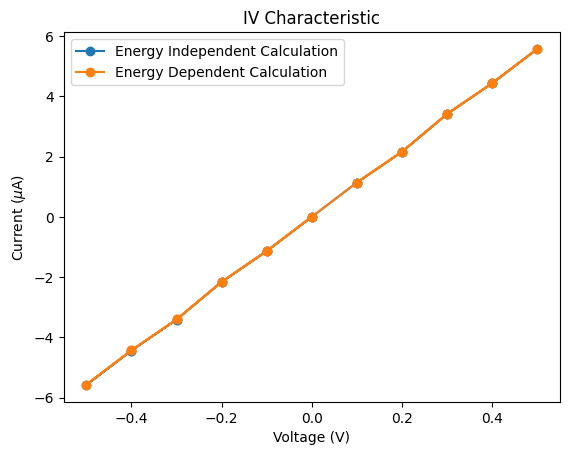

In [26]:
plt.plot(Vlist, [I*1e6 for I in Ilist], '-o')
plt.plot(Vlist, [I*1e6 for I in IlistE], '-o')
plt.xlabel('Voltage (V)')
plt.ylabel(r'Current ($\mu$A)')
plt.title('IV Characteristic')
plt.legend(('Energy Independent Calculation', 'Energy Dependent Calculation'))